# 1. Input data processing


Dataset: https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network#

paper: https://gi.copernicus.org/articles/4/121/2015/gi-4-121-2015.pdf 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

In [2]:
!pip install wget

from numpy.random import multivariate_normal
from scipy.linalg import toeplitz
from numpy.random import randn

import requests
import csv
import wget   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=3d965a6fcc6418e2df1c6cdedb9abe663ec6e0dc0a12a60dd2144a7425160253
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00328/ghg_data.zip'
file_name = 'datasetGHG'
wget.download(url, file_name)
!unzip /content/datasetGHG

In [4]:
# read .dat to feature and label vectors
'''    
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
'''
N = 2921 # number of data 
d = int(5232/16*15) # number of features
count = ["%04d" % x for x in range(1, N+1)]
X = np.zeros((N, d))
avg = np.zeros(N)
for n in range(1, N+1):
    datContent = [i.strip().split() for i in open("./ghg_data/ghg.gid.site{}.dat".format(count[n-1])).readlines()]
    X[n-1,:] = np.array(datContent[:15]).astype(float).reshape((-1))
    avg[n-1] = np.average(np.array(datContent[15]).astype(float))
avgAll = np.average(avg)
y = [-1 if avg[i]<avgAll else 1 for i in range(N)]
y = np.array(y)
# print(X.shape)
# print(y.shape)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \lambda \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \lambda \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.




In [59]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * np.linalg.norm(w) ** 2
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X.T.dot(u))/n_samples + strength * w
    
    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        strength = self.strength
        u = y[i]*np.exp(- y[i] * (x_i.dot(w)))/(1 + np.exp(- y[i] * (x_i.dot(w))))
        return (- u*x_i + strength * w)
    
    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X[:, j].T.dot(u))/n_samples + strength * w[j]

    def lip(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of  f"""
        X, n_samples = self.X, self.n_samples

        return np.linalg.norm(X.T.dot(X), 2) / (4*n_samples) + self.strength

    def lip_coordinates(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples

        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength

    def lip_max(self):
        """Computes (an upper bound on) the maximum of the lipschitz constants of the gradients of  f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()

    def hessian(self):
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()


<a id='solvers'></a>
# 3. Solvers

<a id='tools'></a>
## 3.1. Tools for the solvers

The following tools store the loss after each epoch

In [58]:
model = ModelLogReg(X, y, strength=1e-3)

w0 = np.zeros(model.n_features) # Starting point of all solvers
n_iter = 3000 # Number of iterations

# Random samples indices for the stochastic solvers (sgd, sag, svrg) 
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [60]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.6e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent


In [9]:
def gd(model, w0, step,  n_iter, callback, verbose=True):
    """Gradient descent
    """
    #step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        w_new[:] = w - step * model.grad(w)
        w[:] = w_new # Remark : does operation inplace
        callback(w)
    return w

In [27]:
callback_gd = inspector(model, n_iter=n_iter)
# step= 1/model.lip()
step = 1e-5
w_gd = gd(model, w0, step=step, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.931472e-01
     600 | 1.232079e-01
    1200 | 8.834921e-02
    1800 | 7.295986e-02
    2400 | 6.372120e-02
    3000 | 5.734955e-02


<a id='sgd'></a>
## 3.3. Stochastic gradient descent


In [11]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    mu = model.strength
    w = w0.copy()
    w_ave = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        w -= step * model.grad_i(
            i, w) / (np.sqrt(idx + 1))  # decays at 1/sqrt{k} good choice for convex functions
        # decent choice for strongly convex
        # also possible to use (max(mu*(idx + 1), model.lip())) (choice in the slides)
        #w_ave =  idx/(idx+1)*w_ave + 1/(idx+1)*w
        if idx % n_samples == 0:
            callback(w)  #w_ave
    return w

In [28]:
step = 1e-5
# step = 1 / model.lip_max()
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.931472e-01
     600 | 6.074412e-02
    1200 | 5.153646e-02
    1800 | 4.676292e-02
    2400 | 4.365049e-02
    3000 | 4.134837e-02


<a id='sag'></a>
## 3.4. Stochastic average gradient descent

In [13]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features)) # one gradient per sample n= 60k,  d= 50M  => 3 10^12
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        y_new = model.grad_i(i, w)
        y += (y_new - gradient_memory[i]) / n_samples
        gradient_memory[i] = y_new
        w -= step * y
        if idx % n_samples == 0:
            callback(w)
    return w

In [29]:
# step = 1 / model.lip_max()
step = 1e-5
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.931472e-01
     600 | 9.704412e-04
    1200 | 7.401836e-04
    1800 | 6.742697e-04
    2400 | 6.487402e-04
    3000 | 6.378890e-04


- What happens during the first pass of SAG?
- What is the main problem  of SAG?
- What is  the size of the gradient_memory matrix?

<a id='svrg'></a>
## 3.5. Stochastic variance reduced gradient


In [61]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    temp_sum = 0
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        if idx % n_samples == 0:
            w_old[:] = temp_sum/n_samples
            mu = model.grad(w)
            temp_sum = 0
        i = idx_samples[idx]
        z_new = model.grad_i(i, w)
        z_old = model.grad_i(i, w_old)  ### w_old is the only thinng I keep, I can recompute the gradient f_i (w_old)
        ## SVRG trades memory for computation
        w -= step * (z_new - z_old + mu)
        temp_sum += w
        if idx % n_samples == 0:
            callback(w)
    return w

In [62]:
# step = 1 / model.lip_max()
step = 1e-5
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.931472e-01
     600 | 1.225172e-03
    1200 | 1.093046e-03
    1800 | 1.041545e-03
    2400 | 1.011510e-03
    3000 | 9.899088e-04


<a id='comparison'></a>
# 4. Comparison of all algorithms

In [63]:
# Modify here to only call the methods you have implemented
callbacks = [callback_gd, callback_sgd, callback_sag, callback_svrg]
names = ["GD", "SGD", "SAG", "SVRG"]

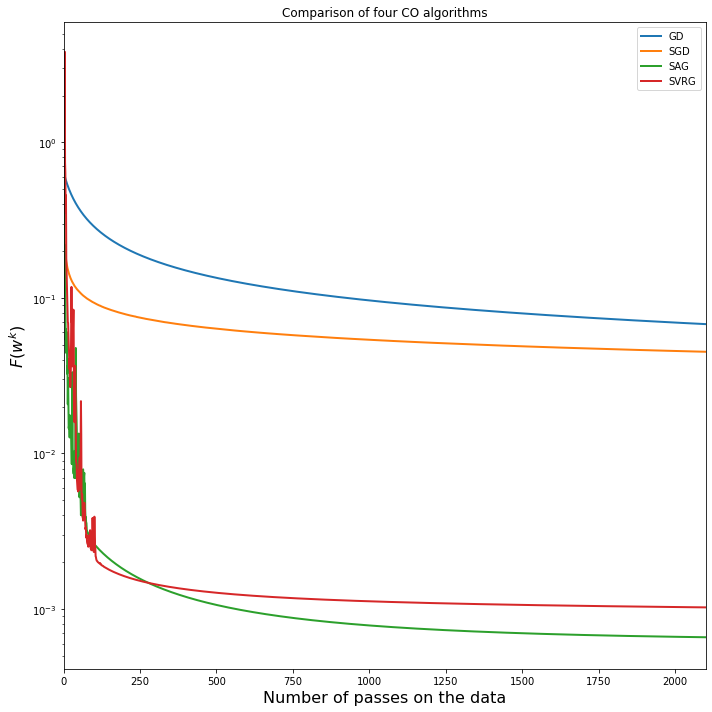

In [65]:
plt.figure(figsize=(10, 10))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives 
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.title("Comparison of four CO algorithms")
plt.xlim((0, n_iter*.7))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) $", fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()

# 5. Problem CA2-(2)

Tune a bit the hyper-parameters (λ) with an example of SVRG

* Grid search: 

Grid search involves selecting a range of values for each hyperparameter and training the model with all possible combinations of hyperparameters in a grid. This can be computationally expensive but guarantees that the optimal combination of hyperparameters will be found.



In [69]:
ngrid = 7
w0 = np.zeros(model.n_features) # Starting point of all solvers
n_iter = 250 # Number of iterations
step = 1e-5
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter) # Random samples indices for the stochastic solvers (sgd, sag, svrg) 
names = []
callbacks = []

for i in range(ngrid):
    print("Ridge normalization strength: {}".format(lamda))
    lamda = 10**(-i)
    model = ModelLogReg(X, y, strength=lamda)
    callback_svrg = inspector(model, n_iter=n_iter)
    w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
                step=step, callback=callback_svrg)
    callbacks.append(callback_svrg)
    names.append("lamda={}".format(lamda))



Ridge normalization strength: 0.0001
   it    |   obj   
       0 | 6.931472e-01
      50 | 1.419598e-01
     100 | 1.855912e-01
     150 | 1.996855e-01
     200 | 9.963379e-02
     250 | 1.491717e-01
Ridge normalization strength: 1
   it    |   obj   
       0 | 6.931472e-01
      50 | 3.160172e-02
     100 | 2.499436e-02
     150 | 2.118873e-02
     200 | 1.861666e-02
     250 | 1.691174e-02
Ridge normalization strength: 0.1
   it    |   obj   
       0 | 6.931472e-01
      50 | 6.317799e-03
     100 | 5.323233e-03
     150 | 4.993681e-03
     200 | 4.803073e-03
     250 | 4.672550e-03
Ridge normalization strength: 0.01
   it    |   obj   
       0 | 6.931472e-01
      50 | 3.915269e-03
     100 | 2.062129e-03
     150 | 1.708272e-03
     200 | 1.502782e-03
     250 | 1.364362e-03
Ridge normalization strength: 0.001
   it    |   obj   
       0 | 6.931472e-01
      50 | 1.141639e-02
     100 | 1.531788e-03
     150 | 1.182519e-03
     200 | 1.007907e-03
     250 | 8.869435e-04
Ridge 

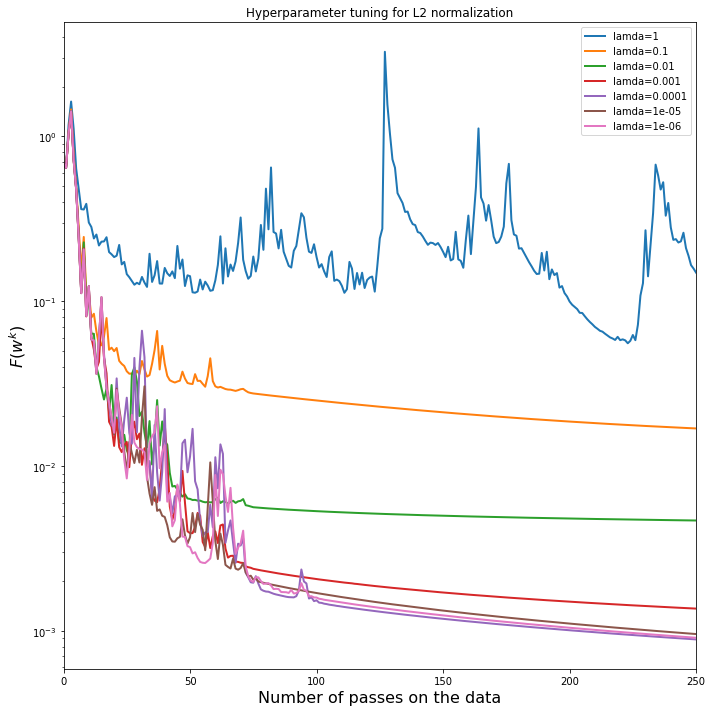

In [70]:
plt.figure(figsize=(10, 10))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives 
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.title("Hyperparameter tuning for L2 normalization")
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) $", fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()

* Analysis from the plot:

The convergence rate makes no much difference when lamda is smaller than 1e-3. 

From this single experiment, we take lamda=1e-4 for a bit smaller loss and less fluctuation. 

Fine tuning could be further done in the range of 1e-6 to 1e-3 with more iterations.

Step size (learning rate) can be tuned in a similar way with a 2D grid.

# 6. Problem CA2-(3)

Compare these solvers (GD, stochastic GD, SVRG, and SAG) in terms of complexity the hyper-parameter tunning, convergence time, convergence rate (in terms of number of outer-loop iterations), and memory requirement.


1.   Gradient Descent (GD):
* Complexity: O(nd), where n is the number of training examples and d is the number of features.
* Hyper-parameter tuning: Usually requires tuning the learning rate.
* Convergence time: Can take a long time to converge for large datasets, but can be faster than other methods for small datasets.
* Convergence rate: Can converge linearly for strongly convex problems, but can be slower for non-convex problems.
* Memory requirement: Only requires memory to store the current model parameters.

2.   Stochastic Gradient Descent (SGD):

* Complexity: O(d), because it only looks at one example at a time.
* Hyper-parameter tuning: Requires tuning the learning rate, as well as the batch size (the number of examples used to estimate the gradient).
* Convergence time: Can converge faster than GD for large datasets, especially when using a small batch size.
* Convergence rate: Can converge slower than GD for strongly convex problems, but can be faster for non-convex problems.
* Memory requirement: Only requires memory to store the current model parameters and the current example.

3. Stochastic Variance Reduced Gradient (SVRG):

* Complexity: O(nd), like GD, but requires more memory.
* Hyper-parameter tuning: Requires tuning the learning rate and the number of epochs (outer-loop iterations).
* Convergence time: Can converge faster than SGD for non-convex problems, because it reduces the variance of the gradients.
* Convergence rate: Can converge linearly for strongly convex problems, and can be faster for non-convex problems than SGD.
* Memory requirement: Requires memory to store the current model parameters and two sets of gradients.

4. Stochastic Average Gradient (SAG):

* Complexity: O(nd), like GD, but requires more memory.
* Hyper-parameter tuning: Requires tuning the learning rate and the number of epochs (outer-loop iterations).
* Convergence time: Can converge faster than GD and SGD for large datasets, because it uses an average of past gradients to reduce the variance.
* Convergence rate: Can converge linearly for strongly convex problems, and can be faster for non-convex problems than GD and SGD.
* Memory requirement: Requires memory to store the current model parameters and the past gradients for each example.